# Data Description:
The features were extracted from the silhouettes by the HIPS (Hierarchical Image Processing System) extension BINATTS, which extracts a combination of scale independent features utilising both classical moments based measures such as scaled variance, skewness and kurtosis about the major/minor axes and heuristic measures such as hollows, circularity, rectangularity and compactness.

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

# Domain:
Automobile

# Context:
The purpose is to classify a given silhouette as one of four types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

# Attribute Information:
1. COMPACTNESS (average perim)**2/area
2. CIRCULARITY (average radius)**2/area
3. DISTANCE CIRCULARITY area/(av.distance from border)**2
4. RADIUS RATIO (max.rad-min.rad)/av.radius
5. PR.AXIS ASPECT RATIO (minor axis)/(major axis)
6. MAX.LENGTH ASPECT RATIO (length perp. max length)/(max length)
7. SCATTER RATIO (inertia about minor axis)/(inertia about major axis)
8. ELONGATEDNESS area/(shrink width)**2
9. PR.AXIS RECTANGULARITY area/(pr.axis length*pr.axis width)
10. MAX.LENGTH RECTANGULARITY area/(max.length*length perp. to this)
11. SCALED VARIANCE (2nd order moment about minor axis)/area (ALONG MAJOR AXIS)
12. SCALED VARIANCE (2nd order moment about major axis)/area (ALONG MINOR AXIS)
13. SCALED RADIUS OF GYRATION (mavar+mivar)/area
14. SKEWNESS ABOUT (3rd order moment about major axis)/sigma_min**3 (MAJOR AXIS)
15. SKEWNESS ABOUT (3rd order moment about minor axis)/sigma_maj**3 (MINOR AXIS)
16. HOLLOWS RATIO (area of hollows)/(area of bounding polygon)

Where sigma_maj**2 is the variance along the major axis and sigma_min**2 is the variance along the minor axis, and

area of hollows= area of bounding poly-area of object

The area of the bounding polygon is found as a side result of the computation to find the maximum length. Each individual length computation yields a pair of calipers to the object orientated at every 5 degrees. The object is propagated into an image containing the union of these calipers to obtain an image of the bounding polygon.

17. target : CAR, BUS, VAN

#### 1. Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### 2. Read the data as a data frame

In [2]:
df = pd.read_csv("d:\\vehicle.csv")

#reading 5 lines from head  
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

<b>Observation : </b> Here "class" column is our dependent variable

In [3]:
print("The dataframe has {} rows and {} columns".format(df.shape[0],df.shape[1]))

The dataframe has 846 rows and 19 columns


In [4]:
#display how many are car,bus,van. 
df['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

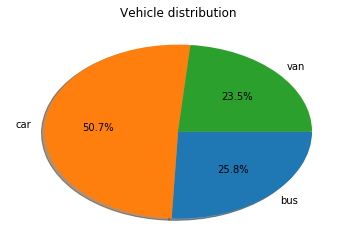

In [5]:
values = list(df[['class']].groupby(['class']).size().values)
labels = list(df[['class']].groupby(['class']).size().keys())
plt.pie(values, labels=labels, autopct='%1.1f%%', counterclock=False, shadow=True,)
plt.title('Vehicle distribution')
plt.show()

<b>Observation : </b> Here most of the vehicles are car so our model will predict better car than van and bus

In [6]:
## Data type of each attribute
df.dtypes

compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                           object
dtype: object

<b>Observation :</b> except 'class' all other attributes are numerical

In [7]:
## Checking the presence of missing values
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

<b>Observation :</b> we have multiple missing value in dataframe

In [8]:
## 5 point summary of numerical attributes
df.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0

<b>Observation : </b> <br>
    i) All the attributes are well distributed.<br>
    ii) it seems few columns have outlier and we need to check further with box plot<br>

In [9]:
### replacing missing value with median
df.fillna(df.median(),axis=0,inplace=True)

In [10]:
#display the info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    846 non-null float64
distance_circularity           846 non-null float64
radius_ratio                   846 non-null float64
pr.axis_aspect_ratio           846 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  846 non-null float64
elongatedness                  846 non-null float64
pr.axis_rectangularity         846 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                846 non-null float64
scaled_variance.1              846 non-null float64
scaled_radius_of_gyration      846 non-null float64
scaled_radius_of_gyration.1    846 non-null float64
skewness_about                 846 non-null float64
skewness_about.1               846 non-null float64
skewness_about.2               846 non-null float64
hollows_ratio    

In [11]:
#display 5 point summary after imputation 
df.describe().transpose()

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.823877    6.134272   33.0   40.00   
distance_circularity         846.0   82.100473   15.741569   40.0   70.00   
radius_ratio                 846.0  168.874704   33.401356  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.677305    7.882188   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.887707   33.197710  112.0  147.00   
elongatedness                846.0   40.936170    7.811882   26.0   33.00   
pr.axis_rectangularity       846.0   20.580378    2.588558   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.596927   31.360427  130.0  167.00   
scaled_variance.1            846.0  439.314421  176.496341  184.0  318.25   
scaled_radius_of_gyration    846.0  174.706856   32.546277  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.468734   59.0   67.00   
skewness_about               846.0    6.361702    4.903244    0.0    2.00   
skewness_about.1             846.0   12.600473    8.930962    0.0    5.00   
skewness_about.2             846.0  188.918440    6.152247  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%     75%     max  
compactness                   93.0  100.00   119.0  
circularity                   44.0   49.00    59.0  
distance_circularity          80.0   98.00   112.0  
radius_ratio                 167.0  195.00   333.0  
pr.axis_aspect_ratio          61.0   65.00   138.0  
max.length_aspect_ratio        8.0   10.00    55.0  
scatter_ratio                157.0  198.00   265.0  
elongatedness                 43.0   46.00    61.0  
pr.axis_rectangularity        20.0   23.00    29.0  
max.length_rectangularity    146.0  159.00   188.0  
scaled_variance              179.0  217.00   320.0  
scaled_variance.1            363.5  586.75  1018.0  
scaled_radius_of_gyration    173.5  198.00   268.0  
scaled_radius_of_gyration.1   71.5   75.00   135.0  
skewness_about                 6.0    9.00    22.0  
skewness_about.1              11.0   19.00    41.0  
skewness_about.2             188.0  193.00   206.0  
hollows_ratio                197.0  201.00   211.0

#### 3. Univariate data analysis : 

Text(0.5,1,'Box Plot')

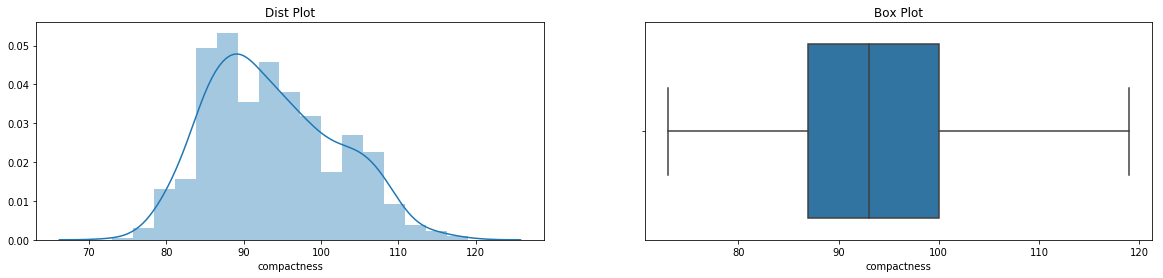

In [12]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['compactness'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['compactness'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in compactness column and it's looks like normally distributed.

Text(0.5,1,'Box Plot')

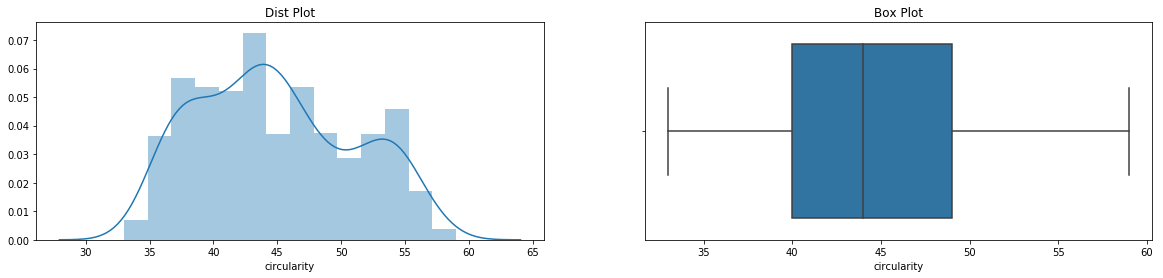

In [13]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['circularity'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['circularity'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in circularity column and it's looks like normally distributed

Text(0.5,1,'Box Plot')

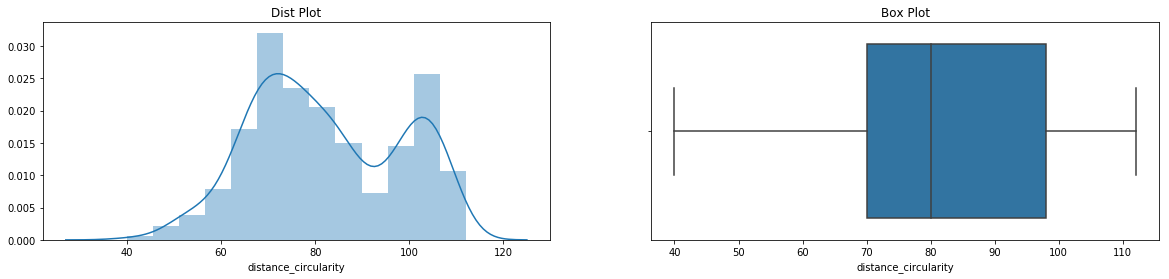

In [14]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['distance_circularity'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['distance_circularity'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in distance_circularity column but in distribution plot we can see that there are two peaks and we can see that there is right skewness because long tail is at the right side(mean>median)

Text(0.5,1,'Box Plot')

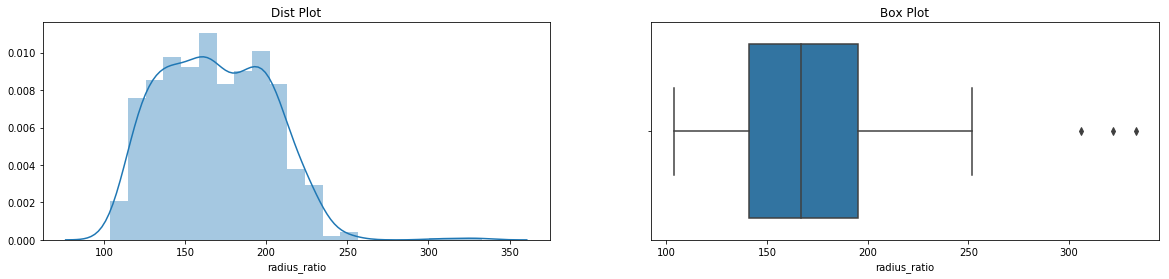

In [15]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['radius_ratio'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['radius_ratio'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in radius_ratio column and there is right skewness because long tail is at the right side(mean>median)

In [16]:
#check how many outliers are there in radius_ratio column
q1 = df['radius_ratio'].quantile(.25)
q2 = df['radius_ratio'].quantile(.50)
q3 = df['radius_ratio'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("radius_ratio above",df['radius_ratio'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in radius_ratio column are",df[df['radius_ratio']>276]['radius_ratio'].shape[0])

Quartie1:: 141.0
Quartie2:: 167.0
Quartie3:: 195.0
Inter Quartie Range:: 54.0
radius_ratio above 276.0 are outliers
The Outliers in radius_ratio column are 3


Text(0.5,1,'Box Plot')

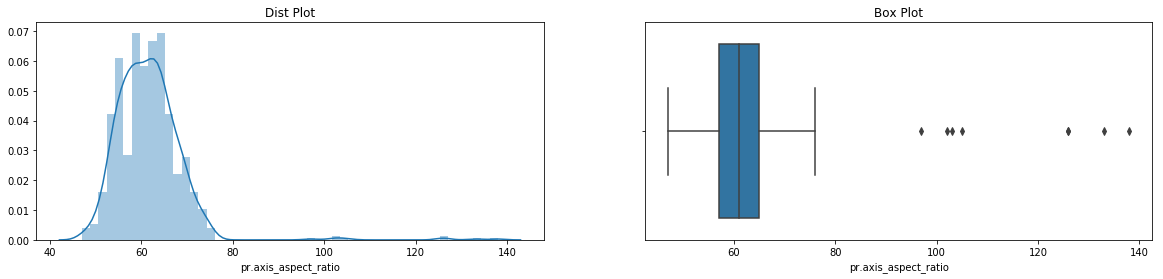

In [17]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['pr.axis_aspect_ratio'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['pr.axis_aspect_ratio'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in pr.axis_aspect_ratio column and there is right skewness because long tail is at right side(mean>median)

In [18]:
#check how many outliers are there in pr.axis_aspect_ratio column
q1 = df['pr.axis_aspect_ratio'].quantile(.25)
q2 = df['pr.axis_aspect_ratio'].quantile(.50)
q3 = df['pr.axis_aspect_ratio'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("pr.axis_aspect_ratio above",df['pr.axis_aspect_ratio'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in pr.axis_aspect_ratio column are",df[df['pr.axis_aspect_ratio']>77]['pr.axis_aspect_ratio'].shape[0])

Quartie1:: 57.0
Quartie2:: 61.0
Quartie3:: 65.0
Inter Quartie Range:: 8.0
pr.axis_aspect_ratio above 77.0 are outliers
The Outliers in pr.axis_aspect_ratio column are 8


Text(0.5,1,'Box Plot')

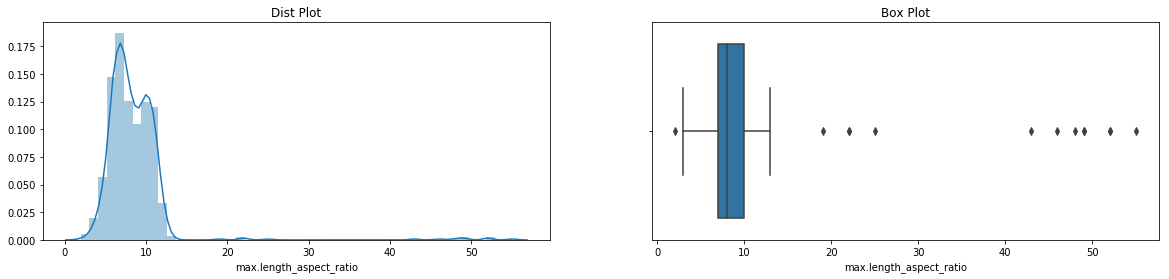

In [19]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['max.length_aspect_ratio'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['max.length_aspect_ratio'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in max.length_aspect_ratio and there is a right skewness because long tail is at right side(mean>median)

In [20]:
#check how many outliers are there in max.length_aspect_ratio column
q1 = df['max.length_aspect_ratio'].quantile(.25)
q2 = df['max.length_aspect_ratio'].quantile(.50)
q3 = df['max.length_aspect_ratio'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("max.length_aspect_ratio above",df['max.length_aspect_ratio'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("max.length_aspect_ratio below",df['max.length_aspect_ratio'].quantile(0.25)-(1.5 * IQR),"are outliers")
print("The above Outliers in max.length_aspect_ratio column are",df[df['max.length_aspect_ratio']>14.5]['max.length_aspect_ratio'].shape[0])
print("The below Outliers in max.length_aspect_ratio column are",df[df['max.length_aspect_ratio']<2.5]['max.length_aspect_ratio'].shape[0])

Quartie1:: 7.0
Quartie2:: 8.0
Quartie3:: 10.0
Inter Quartie Range:: 3.0
max.length_aspect_ratio above 14.5 are outliers
max.length_aspect_ratio below 2.5 are outliers
The above Outliers in max.length_aspect_ratio column are 12
The below Outliers in max.length_aspect_ratio column are 1


Text(0.5,1,'Box Plot')

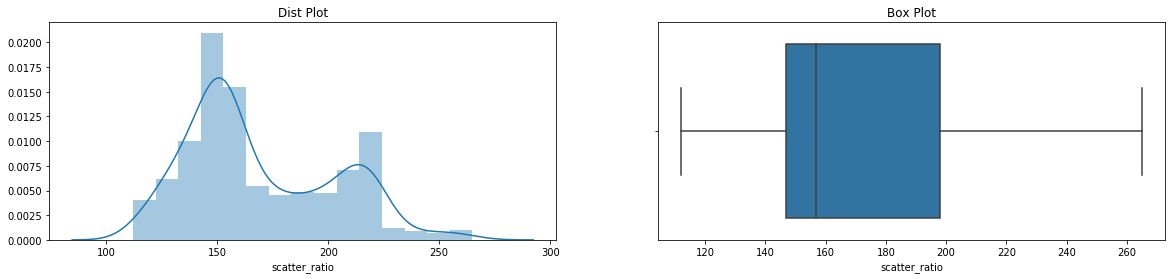

In [21]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['scatter_ratio'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['scatter_ratio'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in scatter_ratio column and there are two peaks in distribution plot and there is right skewness because long tail is at right side(mean>median)

Text(0.5,1,'Box Plot')

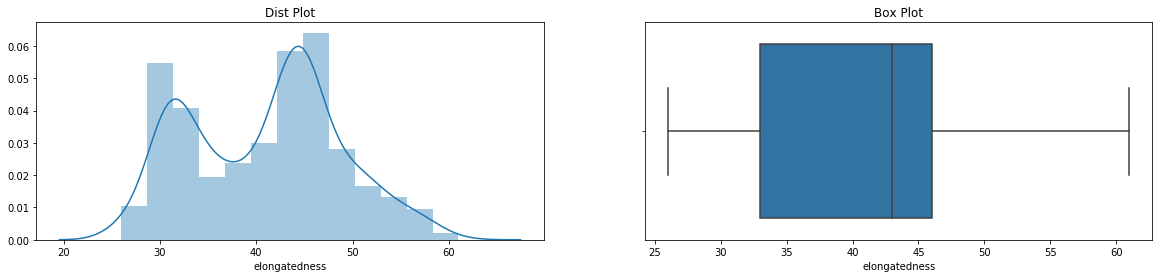

In [22]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['elongatedness'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['elongatedness'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in elongatedness column and there are two peaks in distribution plot and there is left skewness because long tail is at left side(mean<median)

Text(0.5,1,'Box Plot')

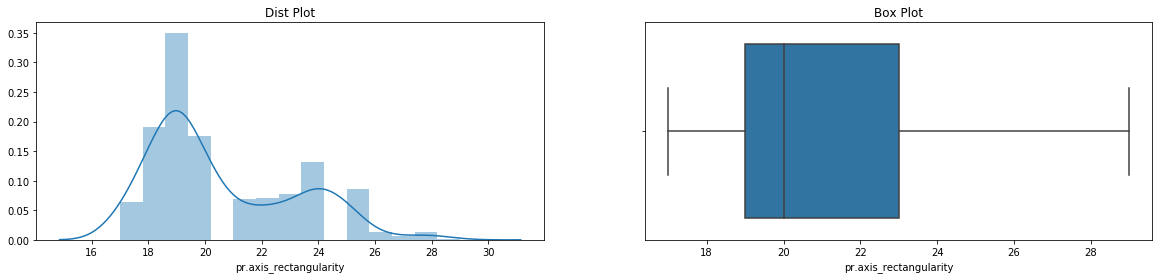

In [23]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['pr.axis_rectangularity'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['pr.axis_rectangularity'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in pr.axis_rectangularity column and there are two peaks in distribution plot and there is right skewness because long tail is at right side(mean>median)

Text(0.5,1,'Box Plot')

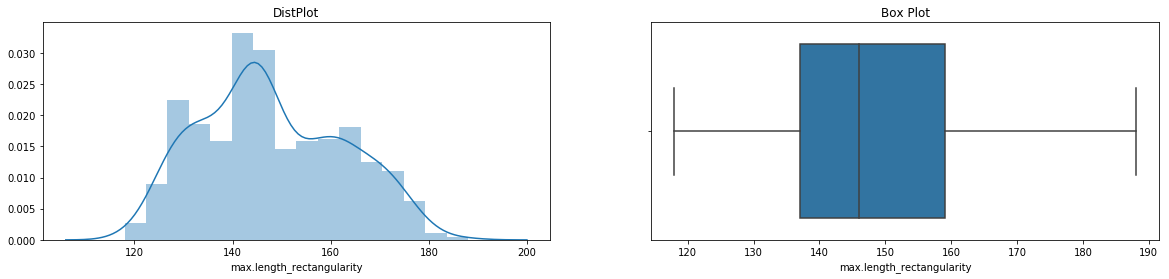

In [24]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['max.length_rectangularity'],ax=ax1)
ax1.set_title("DistPlot")

sns.boxplot(df['max.length_rectangularity'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in max.length_rectangularity column and there are two peaks in distribution plot and there is right skewness because long tail is at right side(mean>median)

Text(0.5,1,'Box Plot')

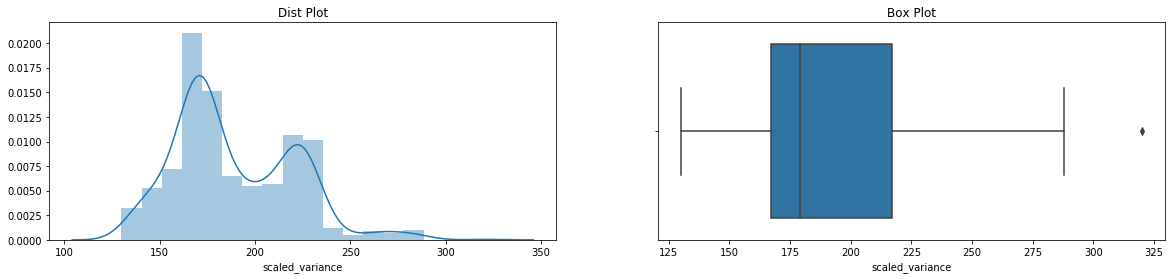

In [25]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['scaled_variance'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['scaled_variance'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in scaled_variance column and there are two peaks in distribution plot and there is right skewness because long tail is at right side(mean>median)

In [26]:
#check how many outliers are there in scaled_variance column
q1 = df['scaled_variance'].quantile(.25)
q2 = df['scaled_variance'].quantile(.50)
q3 = df['scaled_variance'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("scaled_variance above",df['scaled_variance'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in scaled_variance column are",df[df['scaled_variance']>292]['scaled_variance'].shape[0])

Quartie1:: 167.0
Quartie2:: 179.0
Quartie3:: 217.0
Inter Quartie Range:: 50.0
scaled_variance above 292.0 are outliers
The Outliers in scaled_variance column are 1


Text(0.5,1,'Box Plot')

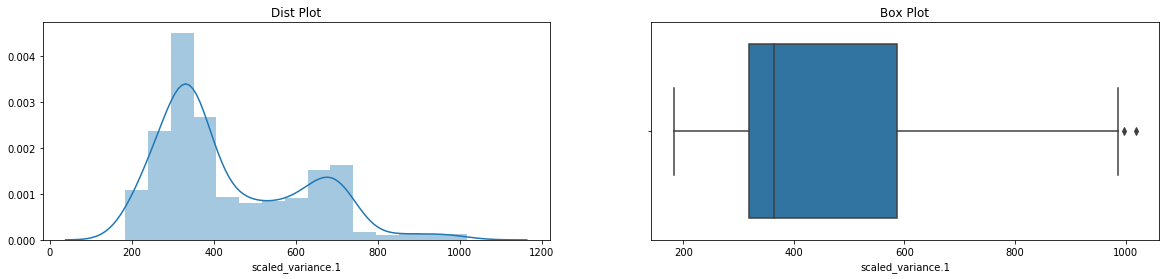

In [27]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['scaled_variance.1'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['scaled_variance.1'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in scaled_variance.1 column and there are two peaks in distribution plot and there is right skewness because long tail is at right side(mean>median)

In [28]:
#check how many outliers are there in scaled_variance.1 column
q1 = df['scaled_variance.1'].quantile(.25)
q2 = df['scaled_variance.1'].quantile(.50)
q3 = df['scaled_variance.1'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("scaled_variance.1 above",df['scaled_variance.1'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in scaled_variance.1 column are",df[df['scaled_variance.1']>989.5]['scaled_variance.1'].shape[0])

Quartie1:: 318.25
Quartie2:: 363.5
Quartie3:: 586.75
Inter Quartie Range:: 268.5
scaled_variance.1 above 989.5 are outliers
The Outliers in scaled_variance.1 column are 2


Text(0.5,1,'Box Plot')

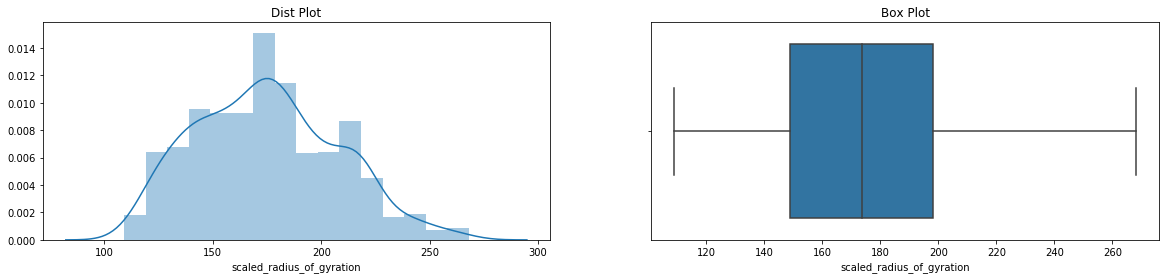

In [29]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['scaled_radius_of_gyration'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['scaled_radius_of_gyration'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in scaled_radius_of_gyration column and there is right skewness because long tail is at right side(mean>median)

Text(0.5,1,'Box Plot')

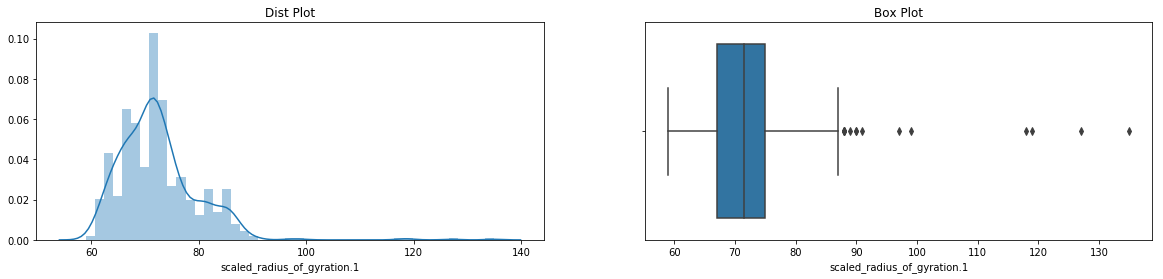

In [30]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['scaled_radius_of_gyration.1'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['scaled_radius_of_gyration.1'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in scaled_radius_of_gyration.1 column and there is right skewness because long tail is at right side(mean>median)

In [31]:
#check how many outliers are there in scaled_radius_of_gyration.1 column
q1 = df['scaled_radius_of_gyration.1'].quantile(.25)
q2 = df['scaled_radius_of_gyration.1'].quantile(.50)
q3 = df['scaled_radius_of_gyration.1'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("scaled_radius_of_gyration.1 above",df['scaled_radius_of_gyration.1'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in scaled_radius_of_gyration.1 column are",df[df['scaled_radius_of_gyration.1']>87]['scaled_radius_of_gyration.1'].shape[0])

Quartie1:: 67.0
Quartie2:: 71.5
Quartie3:: 75.0
Inter Quartie Range:: 8.0
scaled_radius_of_gyration.1 above 87.0 are outliers
The Outliers in scaled_radius_of_gyration.1 column are 15


Text(0.5,1,'Box Plot')

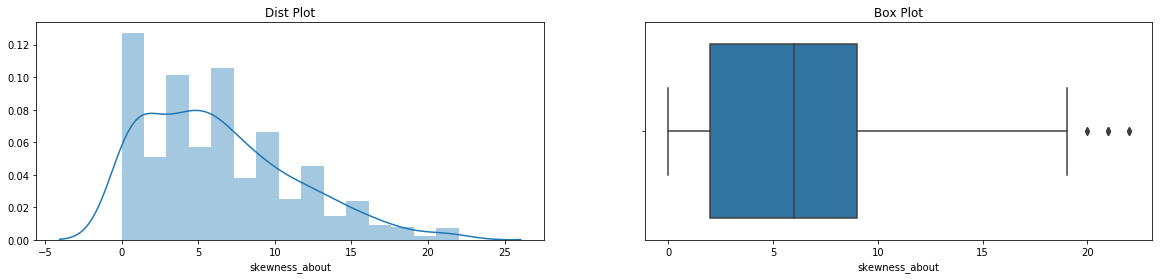

In [32]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['skewness_about'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['skewness_about'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in skewness_about column and there is right skewness because long tail is at right side(mean>median)

In [33]:
#check how many outliers are there in skewness_about column
q1 = df['skewness_about'].quantile(.25)
q2 = df['skewness_about'].quantile(.50)
q3 = df['skewness_about'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("skewness_about above",df['skewness_about'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in skewness_about column are",df[df['skewness_about']>19.5]['skewness_about'].shape[0])

Quartie1:: 2.0
Quartie2:: 6.0
Quartie3:: 9.0
Inter Quartie Range:: 7.0
skewness_about above 19.5 are outliers
The Outliers in skewness_about column are 12


Text(0.5,1,'Box Plot')

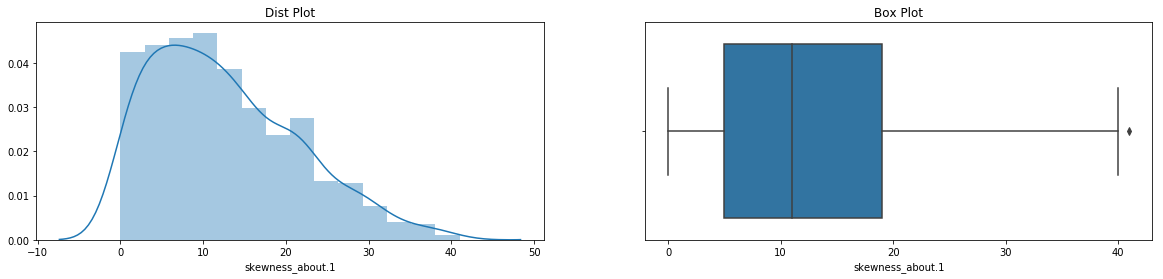

In [34]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['skewness_about.1'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['skewness_about.1'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are outliers in skewness_about.1 column and there is right skewness because long tail is at right side(mean>median)

In [35]:
#check how many outliers are there in skewness_about.1 column
q1 = df['skewness_about.1'].quantile(.25)
q2 = df['skewness_about.1'].quantile(.50)
q3 = df['skewness_about.1'].quantile(.75)
IQR = q3-q1
print("Quartie1::",q1)
print("Quartie2::",q2)
print("Quartie3::",q3)
print("Inter Quartie Range::",IQR)
#outliers = q3 + 1.5*IQR, q1 - 1.5*IQR
print("skewness_about.1 above",df['skewness_about.1'].quantile(0.75)+(1.5 * IQR),"are outliers")
print("The Outliers in skewness_about.1 column are",df[df['skewness_about.1']>40]['skewness_about.1'].shape[0])

Quartie1:: 5.0
Quartie2:: 11.0
Quartie3:: 19.0
Inter Quartie Range:: 14.0
skewness_about.1 above 40.0 are outliers
The Outliers in skewness_about.1 column are 1


Text(0.5,1,'Box Plot')

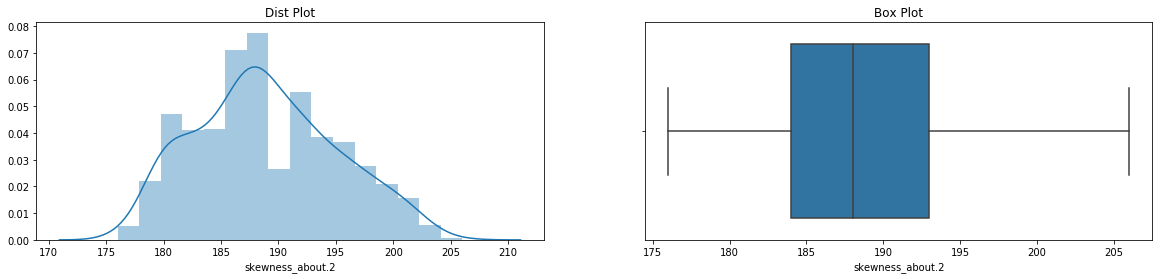

In [36]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['skewness_about.2'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['skewness_about.2'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in skewness_about.2 column and there is left skewness because long tail is at left side(mean<median)

Text(0.5,1,'Box Plot')

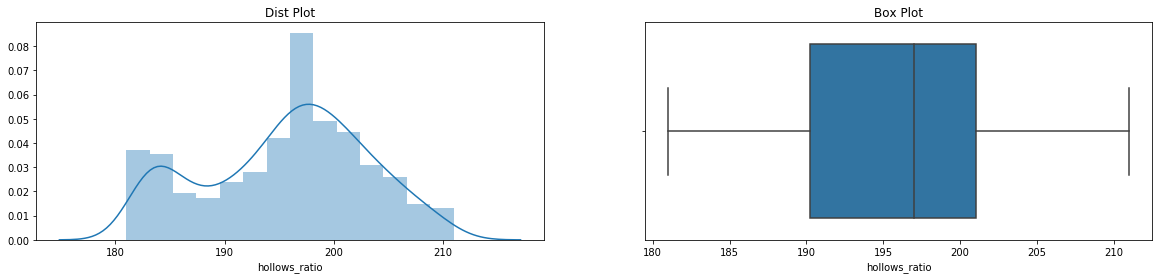

In [37]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,4)
sns.distplot(df['hollows_ratio'],ax=ax1)
ax1.set_title("Dist Plot")

sns.boxplot(df['hollows_ratio'],ax=ax2)
ax2.set_title("Box Plot")

<b>Observation :</b> From above we can see that there are no outliers in hollows_ratio column and there is left skewness because long tail is at left side(mean<median)

after seeing the max values of above outliers column. it's looks like outliers in above columns are natural not a typo mistake or artificial. as we will apply SVM on above data which is affected by outliers. so better to drop those outliers.

In [38]:
#radius_ratio column outliers
df.drop(df[df['radius_ratio']>276].index,axis=0,inplace=True)

In [39]:
#pr.axis_aspect_ratio column outliers
df.drop(df[df['pr.axis_aspect_ratio']>77].index,axis=0,inplace=True)

In [40]:
#max.length_aspect_ratio column outliers
df.drop(df[df['max.length_aspect_ratio']>14.5].index,axis=0,inplace=True)
df.drop(df[df['max.length_aspect_ratio']<2.5].index,axis=0,inplace=True)

In [41]:
#scaled_variance column outliers
df.drop(df[df['scaled_variance']>292].index,axis=0,inplace=True)

In [42]:
#scaled_variance.1 column outliers
df.drop(df[df['scaled_variance.1']>989.5].index,axis=0,inplace=True)

In [43]:
#scaled_radius_of_gyration.1 column outliers
df.drop(df[df['scaled_radius_of_gyration.1']>87].index,axis=0,inplace=True)

In [44]:
#skewness_about column outliers
df.drop(df[df['skewness_about']>19.5].index,axis=0,inplace=True)

In [45]:
#skewness_about.1 column outliers
df.drop(df[df['skewness_about.1']>40].index,axis=0,inplace=True)

In [46]:
#display the shape of data frame
print("after fixing outliers shape of dataframe:",df.shape)

after fixing outliers shape of dataframe: (813, 19)


#### 4. Multivariate data analysis : 

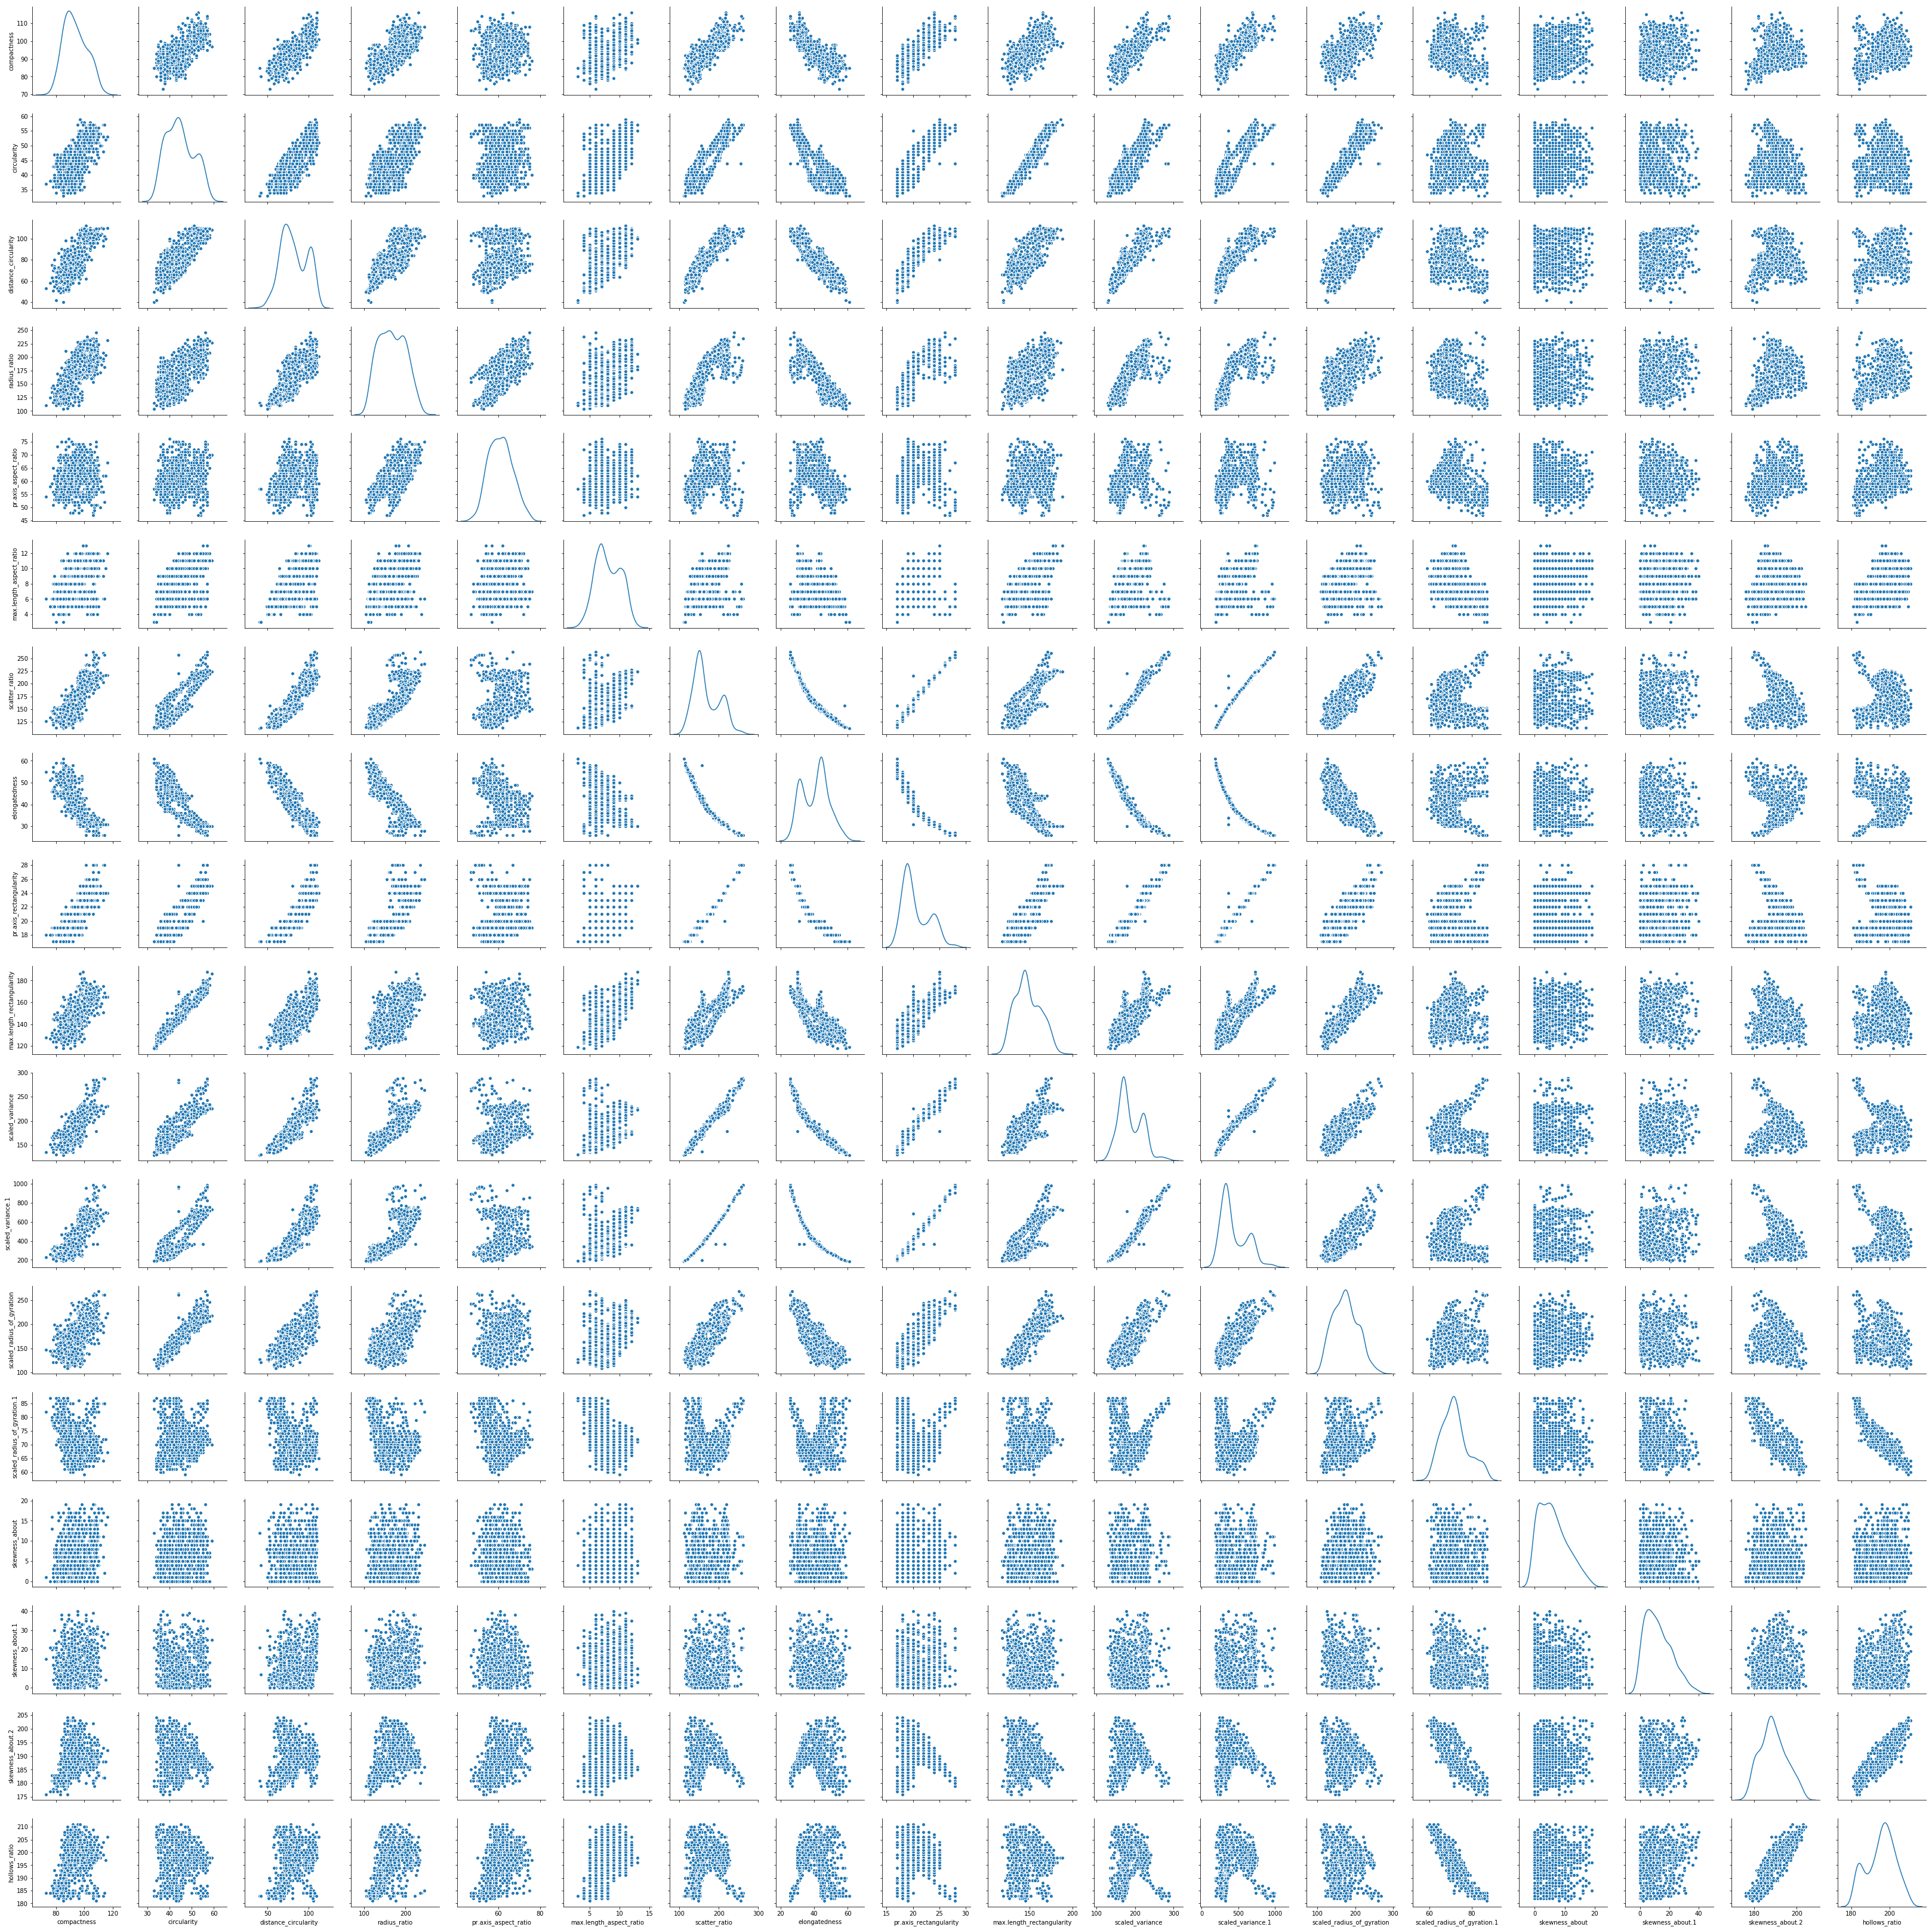

In [47]:
sns.pairplot(data = df,palette="husl", diag_kind="kde")

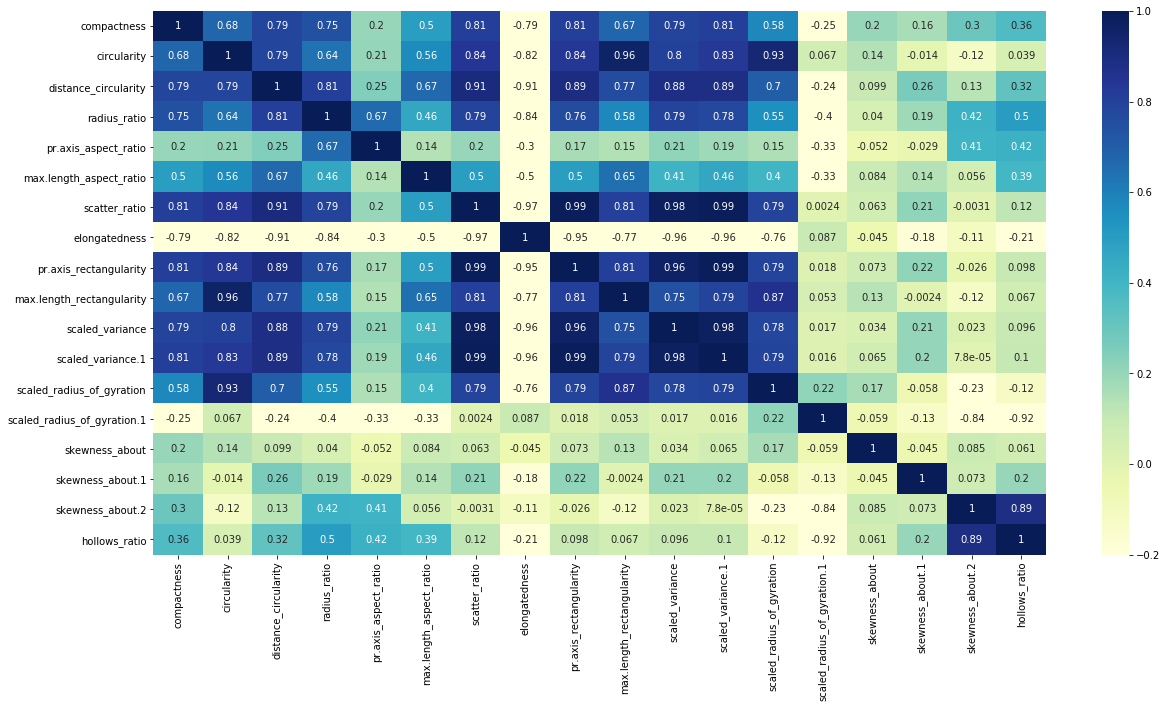

In [48]:
corr = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,cmap='YlGnBu',vmin=-0.2,vmax=1)

<b>Observation :</b> <br>
We observed that more than 50 % of our attributes are highly correlated. There are multiple ways to deal with this problem of Multicollinearity

The easiest way is to delete or eliminate one of the perfectly correlated features. We can pick one of the two highly correalated variables and drop one of them. like in our case Scaled Variance & Scaled Variance.1 are having strong positive correlation , so we can pick one and drop one as they will only make our dimension redundant.
Similarly between elongatedness and pr.axis_rectangularity we can pick one as they have very strong negative correlation. This approach can be used to select the feature we want to carry forward for model analysis. 

But there is another better approach called PCA which we can use for dimension reduction.

#### 5. Dimensionality reduction using PCA :

In [49]:
#separate the dataframe into dependent and independent variables
df_independent_attr = df.drop('class',axis=1)
df_dependent_attr = df['class']
print("shape of df_independent_attr::",df_independent_attr.shape)
print("shape of df_dependent_attr::",df_dependent_attr.shape)

shape of df_independent_attr:: (813, 18)
shape of df_dependent_attr:: (813,)


In [50]:
#sclaed the independent attribute and replace the dependent attr value with number
df_independent_attr_scaled = df_independent_attr.apply(zscore)
df_dependent_attr.replace({'car':0,'bus':1,'van':2},inplace=True)

In [51]:
#make the covariance matrix and we have 18 independent features so aur covariance matrix is 18*18 matrix
cov_matrix = np.cov(df_independent_attr_scaled,rowvar=False)
print("cov_matrix shape:",cov_matrix.shape)
print("Covariance_matrix",cov_matrix)

cov_matrix shape: (18, 18)
Covariance_matrix [[ 1.00123153e+00  6.80164027e-01  7.87792814e-01  7.46906930e-01
   2.00881439e-01  4.98273207e-01  8.11840645e-01 -7.89531434e-01
   8.12866245e-01  6.74996601e-01  7.92438680e-01  8.13494150e-01
   5.78399755e-01 -2.53990635e-01  2.00887113e-01  1.61304844e-01
   2.95777412e-01  3.64608943e-01]
 [ 6.80164027e-01  1.00123153e+00  7.87747162e-01  6.41725205e-01
   2.06409699e-01  5.64854067e-01  8.44804611e-01 -8.16768295e-01
   8.41196310e-01  9.62404205e-01  8.03750964e-01  8.33508154e-01
   9.26281607e-01  6.67790806e-02  1.40563881e-01 -1.43598307e-02
  -1.16976151e-01  3.92302597e-02]
 [ 7.87792814e-01  7.87747162e-01  1.00123153e+00  8.09326627e-01
   2.45756551e-01  6.69657073e-01  9.06692225e-01 -9.09806087e-01
   8.95884623e-01  7.69635504e-01  8.85221631e-01  8.89286924e-01
   7.03348558e-01 -2.38231284e-01  9.89345733e-02  2.63832735e-01
   1.29070982e-01  3.22051625e-01]
 [ 7.46906930e-01  6.41725205e-01  8.09326627e-01  1.00123

In [52]:
#with the help of above covariance matrix we will find eigen value and eigen vectors
pca_to_learn_variance = PCA(n_components=18)
pca_to_learn_variance.fit(df_independent_attr_scaled)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

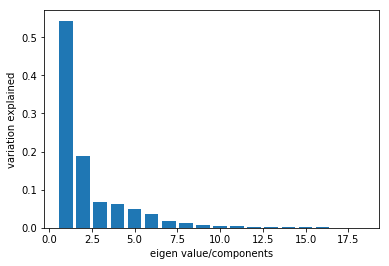

In [53]:
plt.bar(list(range(1,19)),pca_to_learn_variance.explained_variance_ratio_)
plt.xlabel("eigen value/components")
plt.ylabel("variation explained")
plt.show()

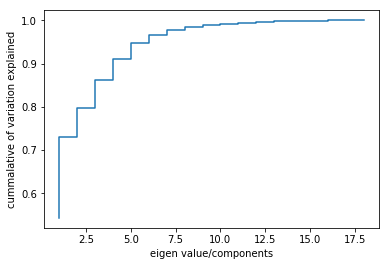

In [54]:
plt.step(list(range(1,19)),np.cumsum(pca_to_learn_variance.explained_variance_ratio_))
plt.xlabel("eigen value/components")
plt.ylabel("cummalative of variation explained")
plt.show()

<b>Observation :</b> From above we can see that 8 dimension are able to explain 95%variance of data. so we will use first 8 principal components

In [55]:
#use first 8 principal components
pca_eight_components = PCA(n_components=8)
pca_eight_components.fit(df_independent_attr_scaled)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
#transform the raw data which is in 18 dimension into 8 new dimension with pca
df_pca_independent_attr = pca_eight_components.transform(df_independent_attr_scaled)

In [57]:
#display the shape of new_vehicle_df_pca_independent_attr
df_pca_independent_attr.shape

(813, 8)

we will make the model using both applying pca with 8 dimension which are explaining more than 95% variantion of data and with raw data. And we will compare both of them

In [58]:
#now split the data into 70:30 ratio
rawdata_X_train,rawdata_X_test,rawdata_y_train,rawdata_y_test = train_test_split(df_independent_attr_scaled,df_dependent_attr,test_size=0.30,random_state=1)
pca_X_train,pca_X_test,pca_y_train,pca_y_test = train_test_split(df_pca_independent_attr,df_dependent_attr,test_size=0.20,random_state=1)

#### 6. Applying SVC to Classify Original Data & PCA treated data sets

In [59]:
# Grid Search
from sklearn.model_selection import GridSearchCV
# Parameter Grid

param_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ] 
# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid, verbose=1)
 
# Train the classifier for raw data
clf_grid.fit(rawdata_X_train, rawdata_y_train)
 
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters:
 {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    3.0s finished


In [60]:
# Train the classifier for pca treated data
clf_grid.fit(pca_X_train, pca_y_train)

print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters:
 {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    8.0s finished


In [61]:
svc_model = SVC (C =50, kernel = "rbf", gamma=0.01)
svc_model.fit(rawdata_X_train, rawdata_y_train)
prediction= svc_model.predict(rawdata_X_test)
print ("Score on Train Data",svc_model.score(rawdata_X_train, rawdata_y_train))
print ("Score on Test Data",svc_model.score(rawdata_X_test, rawdata_y_test))
print ("Confusion Matrix:\n",metrics.confusion_matrix(prediction,rawdata_y_test))
target_names = ['car', 'bus', 'Van']
print(metrics.classification_report(rawdata_y_test, prediction, target_names=target_names))

Score on Train Data 0.9876977152899824
Score on Test Data 0.9877049180327869
Confusion Matrix:
 [[119   0   1]
 [  1  78   0]
 [  1   0  44]]
             precision    recall  f1-score   support

        car       0.99      0.98      0.99       121
        bus       0.99      1.00      0.99        78
        Van       0.98      0.98      0.98        45

avg / total       0.99      0.99      0.99       244



In [62]:
svc_model = SVC (C =50, kernel = "rbf", gamma=0.01)
svc_model.fit(pca_X_train,pca_y_train)
prediction= svc_model.predict(pca_X_test)
print ("Score on Train Data",svc_model.score(pca_X_train,pca_y_train))
print ("Score on Test Data",svc_model.score(pca_X_test, pca_y_test))
print ("Confusion Matrix:\n",metrics.confusion_matrix(prediction,pca_y_test))
target_names = ['car', 'bus', 'Van']
print(metrics.classification_report(pca_y_test, prediction, target_names=target_names))

Score on Train Data 0.9723076923076923
Score on Test Data 0.9447852760736196
Confusion Matrix:
 [[81  0  5]
 [ 2 53  1]
 [ 1  0 20]]
             precision    recall  f1-score   support

        car       0.94      0.96      0.95        84
        bus       0.95      1.00      0.97        53
        Van       0.95      0.77      0.85        26

avg / total       0.95      0.94      0.94       163



<b>Conclusion :</b><br> 
After tuning the parameter the accuracy of model is 98 percentage with all the attribute selected.<br>
But after reducing the dimensionality the accuracy of the model has been decrease to 94 percentage but it will increase the performance of the model. 

#### 7. Applying Some Other Classifier Models on Original Data & PCA treated data sets

<b>Logistic Regression :</b>

In [63]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(rawdata_X_train, rawdata_y_train)
print ('Before PCA score', model.score(rawdata_X_test, rawdata_y_test))

model.fit(pca_X_train, pca_y_train)
print ('After PCA score', model.score(pca_X_test, pca_y_test))

Before PCA score 0.9385245901639344
After PCA score 0.852760736196319


<b>Naive Bayes :</b>

In [64]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(rawdata_X_train, rawdata_y_train)
print ('Before PCA score', nb.score(rawdata_X_test, rawdata_y_test))

nb.fit(pca_X_train, pca_y_train)
print ('After PCA score', nb.score(pca_X_test, pca_y_test))

Before PCA score 0.5819672131147541
After PCA score 0.7852760736196319


<b>Decisiontree Classifier :</b>

In [65]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = 'entropy' )

dt_model.fit(rawdata_X_train, rawdata_y_train)
print ('Before PCA score', dt_model.score(rawdata_X_test, rawdata_y_test))

dt_model.fit(pca_X_train, pca_y_train)
print ('After PCA score', dt_model.score(pca_X_test, pca_y_test))

Before PCA score 0.8729508196721312
After PCA score 0.8711656441717791


<b>Conclusion : </b>It Seems that Support Vectore Classifier is a better model to classifiy the given data.